# Main Analysis- 206A Final 
This notebook brings in the primary dataset we created in several other notebooks. This includes vaccination rates, vaccine distribution center walkshed coverage, COVID-19 cases, and demographic information for each zip code. 

It contains our final data analysis, including mapping the data by the measures we developed and conducting statistical analysis to understand the relationship between COVID-19 Cases, Vaccination Access, Demographics, and COVID-19 Vaccination rates. 

# Initialize

In [1]:
import pandas as pd
import geopandas as gpd
import contextily as ctx

# autocorrelation
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# spatial regression
from pysal.model import spreg
from pysal.lib import weights
from pysal.explore import esda
from scipy import stats
import statsmodels.formula.api as sm
import numpy
import pandas
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
import libpysal.weights.set_operations as Wsets
from libpysal.weights import Queen, KNN
from sklearn.cluster import KMeans, AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt



/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# import megadataframe
gdf = gpd.read_file('/home/jovyan/206a assigment/Midterm/gdf.geojson')

# High/Low Quartile Analysis

We will create quartiles for our primary variables of interest: percent of vaccine distribution walkshed coverage, percent of population vaccinated, COVID-19 case rate.

In [3]:
# create quartiles 

# walkshed coverage
gdf['irank'] = pd.qcut(gdf['%_iso'], 4, labels=["Q1", "Q2", "Q3", "Q4"])
# vaccination rate
gdf['vrank'] = pd.qcut(gdf['%_partial'], 4, labels=["Q1", "Q2", "Q3", "Q4"])
# covid case rate
gdf['crank'] = pd.qcut(gdf['cases_100k'], 4, labels=["Q1", "Q2", "Q3", "Q4"])


Here we will define a function that assigns "high/low" based on the quartiles for two variables. The inputs are a dataframe containing the quartiles (as created in the previous step), the name of the quartile column, and the name of the each variable to be displayed on the map. This will identify which zip codes have high/low rates of the first variable and high/low rates of the second variable. This will help us identify spatial mismatches between variables. 

In [4]:
# Walkshed Coverage and Partial Vaccination High/Low
def high_low(gdf, var1, var2, name1, name2):
    if gdf[var1] == 'Q4' and gdf[var2] == 'Q4':
        return 'High ' +  name1 + ', High ' + name2
    else:
        if gdf[var1] == 'Q1' and gdf[var2] == 'Q1':
            return 'Low ' +  name1 + ', Low ' + name2
        else:
            if gdf[var1] == 'Q4' and gdf[var2] == 'Q1':
                return 'High ' +  name1 + ', Low ' + name2
            else: 
                if gdf[var1] == 'Q1' and gdf[var2] == 'Q4':
                    return 'Low ' +  name1 + ', High ' + name2

In [5]:
# run function to create the high/low column
gdf['quartile_iso_vac'] = gdf.apply(high_low, args = ('irank', 'vrank', 'Vaccination Site Access', 'Vaccination'), axis=1)
gdf['quartile_vac_cases'] = gdf.apply(high_low, args = ('crank', 'vrank', 'COVID Cases', 'Vaccination'), axis=1)
gdf['quartile_iso_cases'] = gdf.apply(high_low, args = ('irank', 'crank', 'Vaccination Site Access', 'COVID Cases'), axis=1)

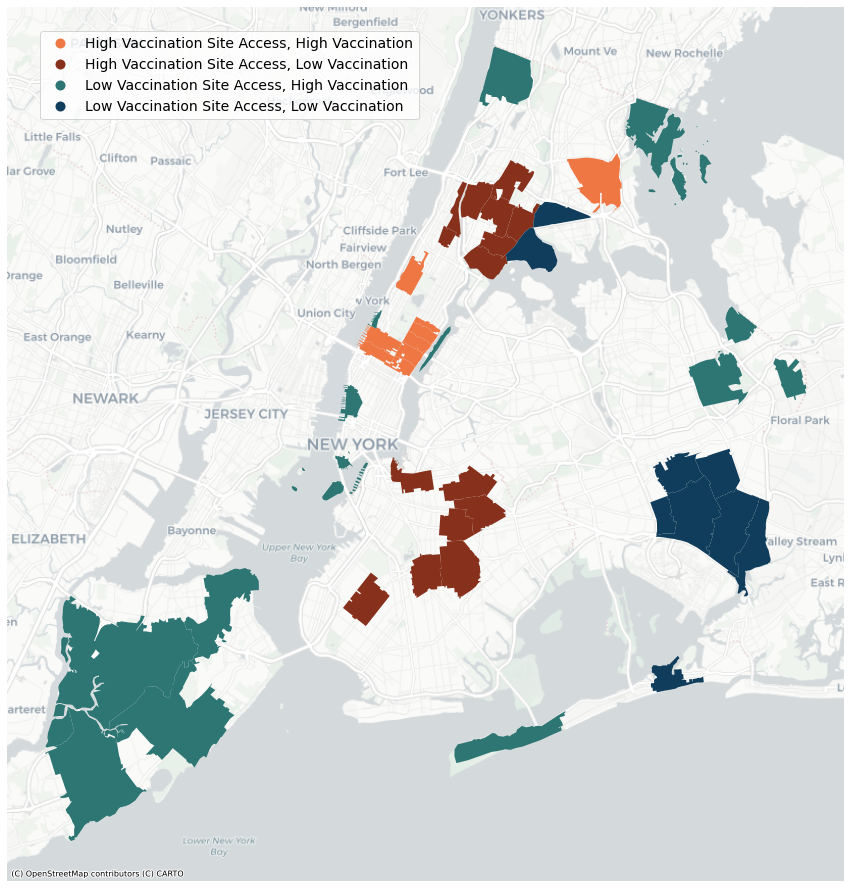

In [6]:
import pylab as plot
params = {'legend.fontsize':14}
plot.rcParams.update(params)

# High/Low Map
#‘#0B2625’, ‘#103D5B’, ‘#2D7673’, ‘#FFC870’, ‘#EE7744’, ‘#87311C’]
from matplotlib.colors import ListedColormap

new_cmap = ListedColormap([ '#EE7744','#87311C', '#2D7673', '#103D5B'])
fig, ax = plt.subplots( figsize=(15,50))


gdf.plot(ax=ax,
         column= 'quartile_iso_vac',
               legend=True, 
              cmap=new_cmap)

leg = ax.get_legend()
leg.set_bbox_to_anchor((.5,.98))


ax.axis('off')


ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)


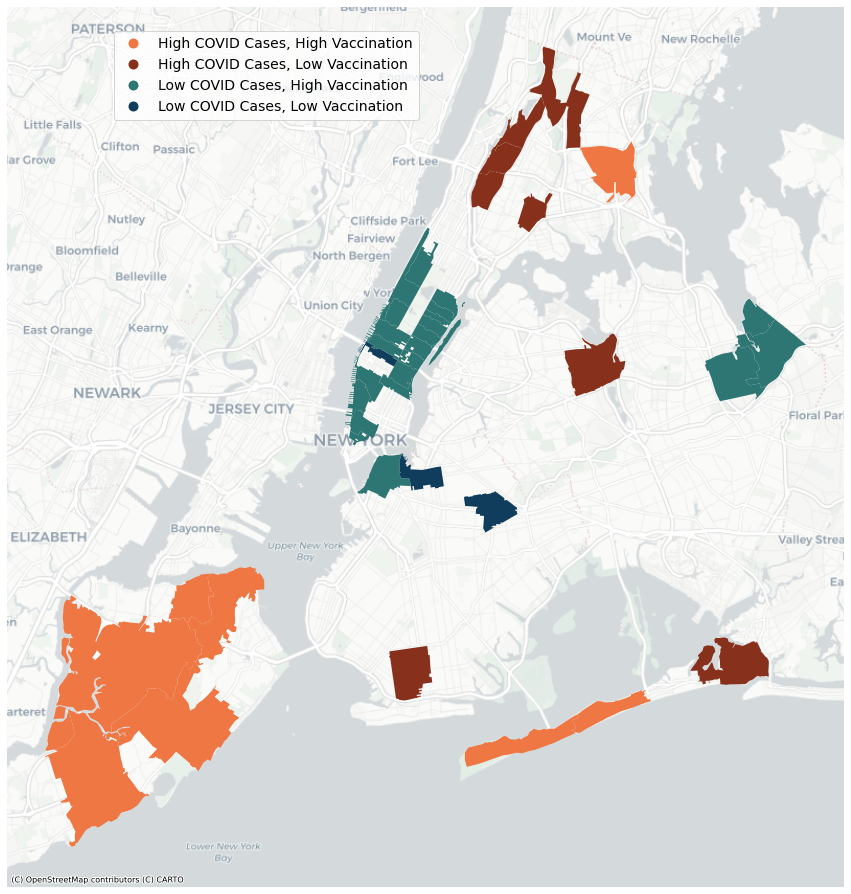

In [7]:
import pylab as plot
params = {'legend.fontsize':14}
plot.rcParams.update(params)

# High/Low Map
#‘#0B2625’, ‘#103D5B’, ‘#2D7673’, ‘#FFC870’, ‘#EE7744’, ‘#87311C’]
from matplotlib.colors import ListedColormap

new_cmap = ListedColormap([ '#EE7744','#87311C', '#2D7673', '#103D5B'])
fig, ax = plt.subplots( figsize=(15,50))


gdf.plot(ax=ax,
         column= 'quartile_vac_cases',
               legend=True, 
              cmap=new_cmap)

leg = ax.get_legend()
leg.set_bbox_to_anchor((.5,.98))


ax.axis('off')


ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)


Next, we will look at the demographics of each "high/low" category to identify explanatory variables in the spatial mismatch. We will look at the median value for each demographic variable.

In [8]:
column_means = ['%_hispanic', '%_white', '%_black', '%_asian', '%_disability', 
    '%_over65', '%_poverty', '%_foreign', '%_lessHS','%_bachelorsbeyond']
median_quart_isovac= gdf.groupby('quartile_iso_vac', as_index=False)[column_means].median()
median_quart_isovac

quartile_iso_vac  %_hispanic    %_white  \
0  High Vaccination Site Access, High Vaccination   15.598598  69.506500   
1   High Vaccination Site Access, Low Vaccination   32.526747   6.343793   
2   Low Vaccination Site Access, High Vaccination   12.253403  58.544827   
3    Low Vaccination Site Access, Low Vaccination   14.686701   1.721709   

     %_black    %_asian  %_disability   %_over65  %_poverty  %_foreign  \
0   3.168255  11.738780     12.012019  21.016574   6.487442  26.676254   
1  36.561796   1.720444     14.382135  10.172202  27.670268  32.990980   
2   3.037570  11.956031     11.603111  18.007876   7.249054  23.739576   
3  62.413225   3.110226     12.631447  13.137628  11.244622  38.249201   

    %_lessHS  %_bachelorsbeyond  
0   4.697083          76.794052  
1  21.822186          24.500306  
2   8.422631          48.536793  
3  17.770245          21.582766

In [9]:
median_quart_vaccases= gdf.groupby('quartile_vac_cases', as_index=False)[column_means].median()
median_quart_vaccases

quartile_vac_cases  %_hispanic    %_white    %_black  \
0  High COVID Cases, High Vaccination   15.427432  67.248291   4.488949   
1   High COVID Cases, Low Vaccination   68.989924   3.336185  26.145671   
2   Low COVID Cases, High Vaccination   10.822484  66.799298   3.189063   
3    Low COVID Cases, Low Vaccination   16.068590  44.286233  28.439681   

     %_asian  %_disability   %_over65  %_poverty  %_foreign   %_lessHS  \
0   5.991090     12.996046  17.629518  10.215963  23.456673  10.584854   
1   2.702607     15.203214  10.106321  27.473105  42.643045  32.028332   
2  12.191730     10.903271  18.737780   7.396167  24.750929   3.850017   
3   6.331789     10.054156   7.256416  27.144034  23.416710  16.640925   

   %_bachelorsbeyond  
0          35.798466  
1          14.927109  
2          79.596765  
3          45.580259

In [10]:
median_quart_isocases= gdf.groupby('quartile_iso_cases', as_index=False)[column_means].median()
median_quart_isocases

quartile_iso_cases  %_hispanic    %_white  \
0  High Vaccination Site Access, High COVID Cases   59.077974  10.437430   
1   High Vaccination Site Access, Low COVID Cases   15.424647  52.635463   
2   Low Vaccination Site Access, High COVID Cases   15.592925  62.434293   
3    Low Vaccination Site Access, Low COVID Cases   10.834411  64.521345   

     %_black    %_asian  %_disability   %_over65  %_poverty  %_foreign  \
0  16.664569   6.646706     15.514144  14.038722  26.734811  37.012909   
1   8.091676   8.959878     11.492332  14.201358  13.763001  24.752529   
2   3.190707   6.293103     12.061307  16.914419   9.127803  23.780092   
3   2.412824  19.885872      7.188894   9.962089   6.962921  31.102029   

    %_lessHS  %_bachelorsbeyond  
0  26.783031          23.977115  
1   8.276990          70.771064  
2  10.368858          35.583800  
3   1.483942          85.189601

In [11]:
import plotly.graph_objects as go

colors = ['#0B2625', '#103D5B', '#2D7673','#9DB17C', '#FFC870', '#EE7744', '#87311C']
fig = go.Figure(data=[
    go.Bar(name='Percent White', x=median_quart_isovac.quartile_iso_vac, y=median_quart_isovac['%_white'], marker_color='#0B2625', text=median_quart_isovac['%_white']),
    go.Bar(name='Percent Hispanic', x=median_quart_isovac.quartile_iso_vac, y=median_quart_isovac['%_hispanic'], marker_color='#103D5B', text=median_quart_isovac['%_hispanic']),
    go.Bar(name='Percent Black', x=median_quart_isovac.quartile_iso_vac,  y=median_quart_isovac['%_black'], marker_color='#2D7673', text=median_quart_isovac['%_black']),
    go.Bar(name='Percent Asian', x=median_quart_isovac.quartile_iso_vac,  y=median_quart_isovac['%_asian'], marker_color='#9DB17C', text=median_quart_isovac['%_asian']),
    go.Bar(name='Percent Adults Over 65', x=median_quart_isovac.quartile_iso_vac,  y=median_quart_isovac['%_over65'], marker_color='#FFC870', text=median_quart_isovac['%_over65']),
    go.Bar(name='Percent Living in Poverty', x=median_quart_isovac.quartile_iso_vac,  y=median_quart_isovac['%_poverty'], marker_color='#EE7744', text=median_quart_isovac['%_poverty']),
    go.Bar(name='Percent College Educated', x=median_quart_isovac.quartile_iso_vac,  y=median_quart_isovac['%_bachelorsbeyond'], marker_color='#87311C', text=median_quart_isovac['%_bachelorsbeyond'])])

                
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_xaxes(type='category')
fig.update_layout(
    title='Vaccination Site Access and Vaccination Rate: Demographics',
    yaxis_title='Average Percent',
    legend_title='Legend Title',
      barmode='stack', xaxis_tickangle=25,xaxis_rangeselector_xanchor='left',
    uniformtext=dict(mode="hide", minsize=10)
)

fig.update_xaxes(title_font_size=10,title_standoff=5, rangeselector_xanchor='left')

fig.show()




In [12]:
colors = ['#0B2625', '#103D5B', '#2D7673', '#FFC870', '#EE7744', '#87311C']
fig = go.Figure(data=[
    go.Bar(name='Percent White', x=median_quart_vaccases.quartile_vac_cases, y=median_quart_vaccases['%_white'], marker_color='#0B2625', text=median_quart_vaccases['%_white']),
    go.Bar(name='Percent Hispanic', x=median_quart_vaccases.quartile_vac_cases, y=median_quart_vaccases['%_hispanic'], marker_color='#103D5B', text=median_quart_vaccases['%_hispanic']),
    go.Bar(name='Percent Black', x=median_quart_vaccases.quartile_vac_cases,  y=median_quart_vaccases['%_black'], marker_color='#2D7673', text=median_quart_vaccases['%_black']),
    go.Bar(name='Percent Asian', x=median_quart_vaccases.quartile_vac_cases,  y=median_quart_vaccases['%_asian'], marker_color='#9DB17C', text=median_quart_vaccases['%_asian']),
    go.Bar(name='Percent Adults Over 65', x=median_quart_vaccases.quartile_vac_cases,  y=median_quart_vaccases['%_over65'], marker_color='#FFC870', text=median_quart_vaccases['%_over65']),
    go.Bar(name='Percent Living in Poverty', x=median_quart_vaccases.quartile_vac_cases,  y=median_quart_vaccases['%_poverty'], marker_color='#EE7744', text=median_quart_vaccases['%_poverty']),
    go.Bar(name='Percent College Educated', x=median_quart_vaccases.quartile_vac_cases,  y=median_quart_vaccases['%_bachelorsbeyond'], marker_color='#87311C', text=median_quart_vaccases['%_bachelorsbeyond'])])

                
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_xaxes(type='category')
fig.update_layout(
    title='COVID-19 Cases and Vaccination Rate: Demographics',
    yaxis_title='Average Percent',
    legend_title='Legend Title',
      barmode='stack', xaxis_tickangle=25,xaxis_rangeselector_xanchor='right',
    uniformtext=dict(mode="hide", minsize=10)
)

fig.update_xaxes(title_font_size=10,title_standoff=5, rangeselector_xanchor='left')

fig.show()


This high/low analysis is really valuable. We were able to observed both the spatial and demographic mistmach in vaccination rates .

# Spatial Regression
The following workflow is taken from [Geographic Data Science for Python: Spatial Regression](https://geographicdata.science/book/notebooks/11_regression.html). Spatial regression doesn't seem to be the best analysis tool for our dataset -- I think it is better suited for point data with a larger number of observations. However, the results of the multivariate regression are interesting, and we could further refine the model in the future.

## Spatial Regression with COVID data

In [13]:
# store explanatory variable names in a list
variable_names = ['cases_100k',  '%_iso']

In [14]:
# non-spatial multivariate regression
m1 = spreg.OLS(gdf['%_partial'].values, gdf[variable_names].values,
                name_y='%_partial', name_x=variable_names)


print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   %_partial                Number of Observations:         177
Mean dependent var  :     21.6497                Number of Variables   :           3
S.D. dependent var  :      7.0107                Degrees of Freedom    :         174
R-squared           :      0.0601
Adjusted R-squared  :      0.0493
Sum squared residual:    8130.103                F-statistic           :      5.5664
Sigma-square        :      46.725                Prob(F-statistic)     :    0.004537
S.E. of regression  :       6.836                Log likelihood        :    -589.857
Sigma-square ML     :      45.933                Akaike info criterion :    1185.715
S.E of regression ML:      6.7774                Schwarz criterion     :    1195.243

-----------------------------------------------------------------------------

## Spatial Regression with Other Demographic Data

In [15]:
# including people over 65, living in poverty, foreign born, no high school education
variable_names_2 = ['cases_100k', '%_iso', '%_hispanic',
 '%_black',
 '%_asian',
 '%_over65']

In [16]:
m3 = spreg.OLS(gdf['%_partial'].values, gdf[variable_names_2].values,
                name_y='%_partial', name_x=variable_names_2)


print(m3.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   %_partial                Number of Observations:         177
Mean dependent var  :     21.6497                Number of Variables   :           7
S.D. dependent var  :      7.0107                Degrees of Freedom    :         170
R-squared           :      0.6073
Adjusted R-squared  :      0.5934
Sum squared residual:    3397.219                F-statistic           :     43.8114
Sigma-square        :      19.984                Prob(F-statistic)     :   4.408e-32
S.E. of regression  :       4.470                Log likelihood        :    -512.631
Sigma-square ML     :      19.193                Akaike info criterion :    1039.262
S.E of regression ML:      4.3810                Schwarz criterion     :    1061.495

-----------------------------------------------------------------------------

## Spatial Regression and Education

In [17]:
# including people over 65, living in poverty, foreign born, no high school education
variable_names_3 = ['cases_100k', '%_iso', '%_hispanic',
 '%_black',
 '%_asian',
 '%_over65', '%_bachelorsbeyond']

In [18]:
m3 = spreg.OLS(gdf['%_partial'].values, gdf[variable_names_3].values,
                name_y='%_partial', name_x=variable_names_3)


print(m3.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   %_partial                Number of Observations:         177
Mean dependent var  :     21.6497                Number of Variables   :           8
S.D. dependent var  :      7.0107                Degrees of Freedom    :         169
R-squared           :      0.7397
Adjusted R-squared  :      0.7290
Sum squared residual:    2251.287                F-statistic           :     68.6230
Sigma-square        :      13.321                Prob(F-statistic)     :   3.947e-46
S.E. of regression  :       3.650                Log likelihood        :    -476.217
Sigma-square ML     :      12.719                Akaike info criterion :     968.434
S.E of regression ML:      3.5664                Schwarz criterion     :     993.844

-----------------------------------------------------------------------------

## checking the relationshipt between Race and Education

In [19]:
variable_names_4 = [ '%_hispanic',
 '%_black',
 '%_asian',]

In [20]:
m4 = spreg.OLS(gdf['%_bachelorsbeyond'].values, gdf[variable_names_4].values,
                name_y= '%_bachelorsbeyond', name_x=variable_names_4)


print(m4.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :%_bachelorsbeyond                Number of Observations:         177
Mean dependent var  :     41.2556                Number of Variables   :           4
S.D. dependent var  :     21.7256                Degrees of Freedom    :         173
R-squared           :      0.6100
Adjusted R-squared  :      0.6032
Sum squared residual:   32400.879                F-statistic           :     90.1842
Sigma-square        :     187.288                Prob(F-statistic)     :   3.526e-35
S.E. of regression  :      13.685                Log likelihood        :    -712.219
Sigma-square ML     :     183.056                Akaike info criterion :    1432.437
S.E of regression ML:     13.5298                Schwarz criterion     :    1445.142

------------------------------------------------------------------------

In [21]:
m5 = spreg.OLS(gdf['%_lessHS'].values, gdf[variable_names_4].values,
                name_y= '%_lessHS', name_x=variable_names_4)


print(m5.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :    %_lessHS                Number of Observations:         177
Mean dependent var  :     16.1046                Number of Variables   :           4
S.D. dependent var  :      9.5626                Degrees of Freedom    :         173
R-squared           :      0.7212
Adjusted R-squared  :      0.7164
Sum squared residual:    4487.000                F-statistic           :    149.1732
Sigma-square        :      25.936                Prob(F-statistic)     :   9.342e-48
S.E. of regression  :       5.093                Log likelihood        :    -537.254
Sigma-square ML     :      25.350                Akaike info criterion :    1082.508
S.E of regression ML:      5.0349                Schwarz criterion     :    1095.213

-----------------------------------------------------------------------------

# Conclusion
Through this analysis we were able to examine what factors affect vaccination rates in NYC city. 